In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from IPython.display import Image
from collections import deque
from scipy.stats import norm
import glob
import cv2
from tqdm import tqdm
from io import BytesIO
%matplotlib inline

In [2]:
def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control
    # overall luminosity
    vmax = 255 if arr.dtype == 'uint8' else 1.0
#     vmax=1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap,
                         vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)


In [3]:
img_path='/Volumes/LaCie/RoboND P1'

def load_images(img_path=img_path, glob_regex='/background/*.JPG'):
    images = []
    files = []
    
    fs = glob.glob(img_path+glob_regex)

    pbar = tqdm(total=len(fs))
    for f in fs:
        img = cv2.imread(f)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
        images.append(img)
        files.append(f)
        pbar.update(1)
        #print(f,img.shape)

    return images, files

In [4]:
imgs={}
imgs['background']=load_images(glob_regex='/background/*.JPG')

100%|██████████| 322/322 [01:14<00:00,  4.22it/s]

In [5]:
imgs['not-pedestrian']=load_images(glob_regex='/not-pedestrian/*.JPG')


 22%|██▏       | 21/94 [00:05<00:17,  4.06it/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/nick/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/nick/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/nick/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 94/94 [00:22<00:00,  4.05it/s]


In [6]:
imgs['pedestrian']=load_images(glob_regex='/pedestrian/*.JPG')

100%|██████████| 349/349 [01:20<00:00,  4.34it/s]

In [7]:
background_images,background_files=imgs['background']
not_pedestrian_images,not_pedestrian_files=imgs['not-pedestrian']
pedestrian_images,pedestrian_files=imgs['pedestrian']

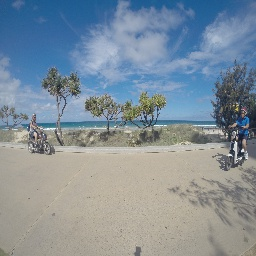

In [8]:
arr2img(not_pedestrian_images[90])

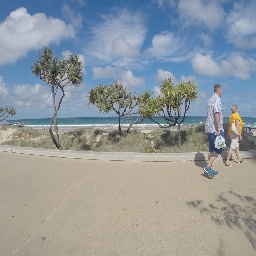

In [9]:
arr2img(pedestrian_images[90])

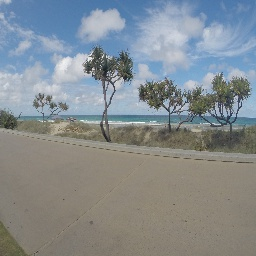

In [10]:
arr2img(background_images[90])

In [97]:
def randomise_image_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # brightness
    bv = .2 + np.random.random()
    hsv[:,:,2] = hsv[:,:,2]*bv

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    
def jitter_image_rotation(image):
    rows, cols, _ = image.shape
    transRange = 50
    numPixels = 100
    
    if np.random.uniform() <= 0.5:
        image = cv2.flip(image, 1)

    transX = transRange * np.random.uniform() - transRange/2
    transY = numPixels * np.random.uniform() - numPixels/2
    transMat = np.float32([[1,0, transX], [0,1, transY]])
    image = cv2.warpAffine(image, transMat, (cols, rows))
    return image

In [98]:
def plot_jitter_sample(image):
    img2 = randomise_image_brightness(image)
    img3 = jitter_image_rotation(img2)
    
    fig = plt.figure(dpi=200)
    gs1 = gridspec.GridSpec(1,3,wspace=0.05)
    fig.add_subplot(gs1[0])
    plt.title('original')
    plt.axis('off')
    plt.imshow(image)
    fig.add_subplot(gs1[1])
    plt.title('brightness')
    plt.axis('off')
    plt.imshow(img2)
    fig.add_subplot(gs1[2])
    plt.title('jitter')
    plt.axis('off')
    plt.imshow(img3)

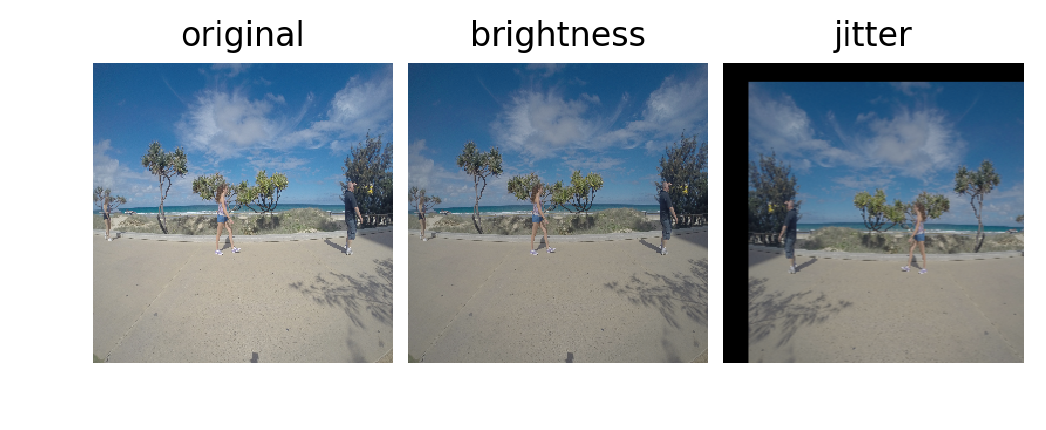

In [99]:
plot_jitter_sample(pedestrian_images[70])

In [100]:
def jitter_generator(images):
    while True:
        for image in images:
            img2 = randomise_image_brightness(image)
            img3 = jitter_image_rotation(img2) 
            yield img3                             

def top_n(n, generator):
    return [x for _, x in zip(range(n), generator)]

In [101]:
not_pedestrian_jittered = top_n(2000, jitter_generator(not_pedestrian_images))
pedestrian_jittered = top_n(1000, jitter_generator(pedestrian_images))
background_jittered = top_n(1000, jitter_generator(background_images))

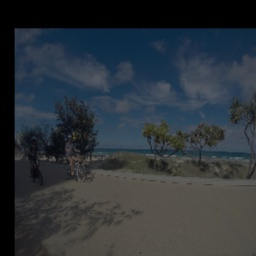

In [102]:
arr2img(not_pedestrian_jittered[650])

In [103]:
img_path='/Volumes/LaCie/RoboND P1/jittered'

def write_images(sub, images):

    pbar = tqdm(total=len(images))
    count = 0
    for img in images:
        img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        name='%s-%d.png' % (sub, count)
        cv2.imwrite(img_path+'/'+sub+'/'+name, img)
        pbar.update(1)
        count += 1 

In [104]:
write_images('not-pedestrian', not_pedestrian_jittered)

100%|█████████▉| 1994/2000 [00:13<00:00, 151.63it/s]

In [105]:
write_images('pedestrian', pedestrian_jittered)


100%|██████████| 2000/2000 [00:20<00:00, 99.98it/s] [A
Exception in thread Thread-20:
Traceback (most recent call last):
  File "/Users/nick/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/nick/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/nick/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 1000/1000 [00:07<00:00, 127.62it/s]


In [106]:
write_images('background', background_jittered)

100%|██████████| 1000/1000 [00:06<00:00, 154.57it/s]
